In [389]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
import itertools
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna
from tqdm import tqdm

# Business and Data Understanding

# Data Collection

In [390]:
df = pd.read_csv('./datasets/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Data Cleaning & Analysis

### Check Data

In [391]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [392]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [393]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [394]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


### Check null value

In [395]:
df.isnull().head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False


### Replace 0 value with nan

In [396]:
df_copy = df.copy(deep=True)
df_copy[
    [
        'Glucose',
        'BloodPressure',
        'SkinThickness',
        'Insulin',
        'BMI',
    ]
] = df_copy[[
    'Glucose', 
    'BloodPressure',
    'SkinThickness',
    'Insulin',
    'BMI'
]].replace(0,np.NaN)

In [397]:
print(df_copy.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


### Data Visualization

C:\Users\Hammam\AppData\Local\Temp\ipykernel_18560\476224857.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


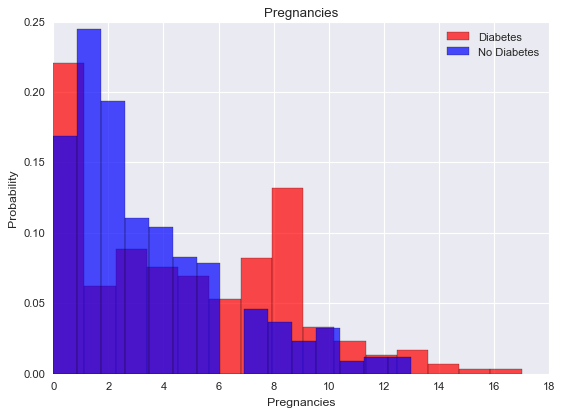

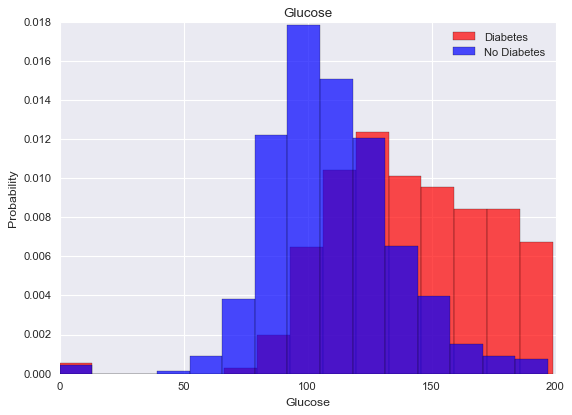

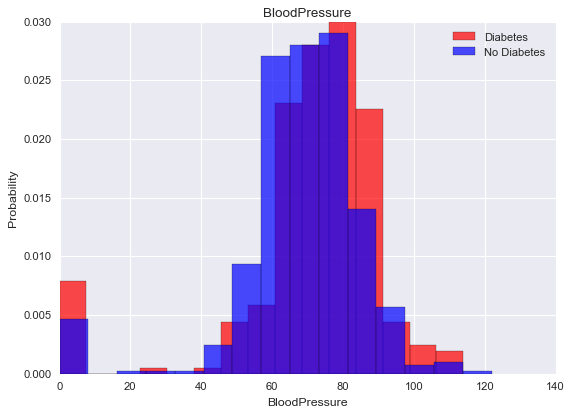

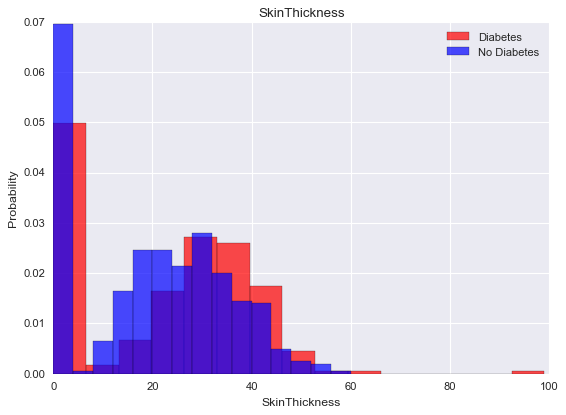

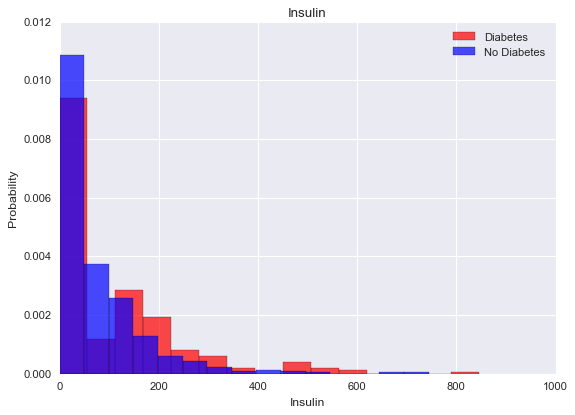

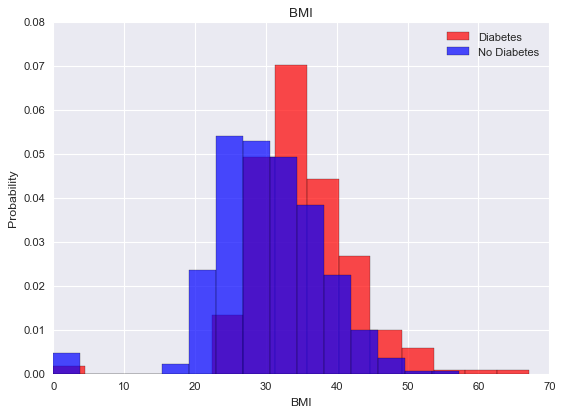

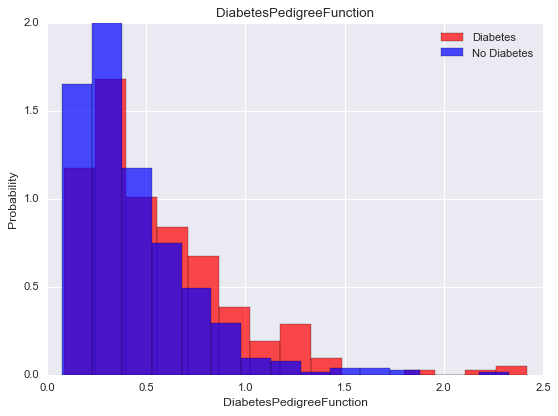

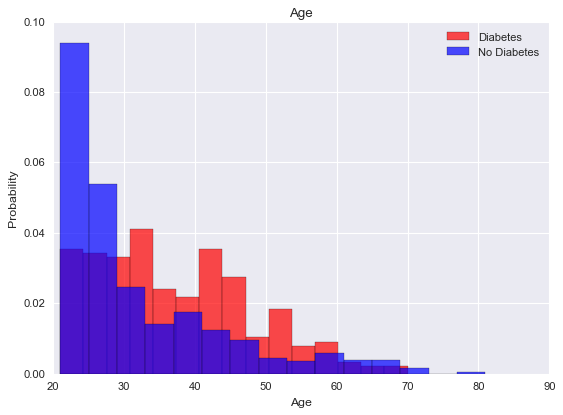

In [398]:
plt.style.use('seaborn')

# df.hist(figsize= (20, 20))
for i in range(len(df.columns[:-1])):
    label = df.columns[i]
    plt.hist(
        df[df['Outcome'] == 1][label],
        color='red',
        label='Diabetes',
        alpha=0.7,
        density=True,
        bins=15
    )

    plt.hist(
        df[df['Outcome'] == 0][label],
        color='blue',
        label='No Diabetes',
        alpha=0.7,
        density=True,
        bins=15
    )

    plt.title(label)
    plt.ylabel('Probability')
    plt.xlabel(label)
    plt.legend()
    plt.show()

### Fill Nan Value with mean or median

In [399]:
df_copy['Glucose'].fillna(df_copy['Glucose'].mean(), inplace = True)
df_copy['BloodPressure'].fillna(df_copy['BloodPressure'].mean(), inplace = True)
df_copy['SkinThickness'].fillna(df_copy['SkinThickness'].median(), inplace = True)
df_copy['Insulin'].fillna(df_copy['Insulin'].median(), inplace = True)
df_copy['BMI'].fillna(df_copy['BMI'].median(), inplace = True)

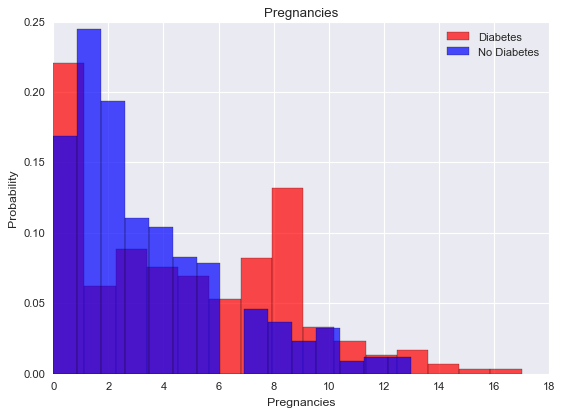

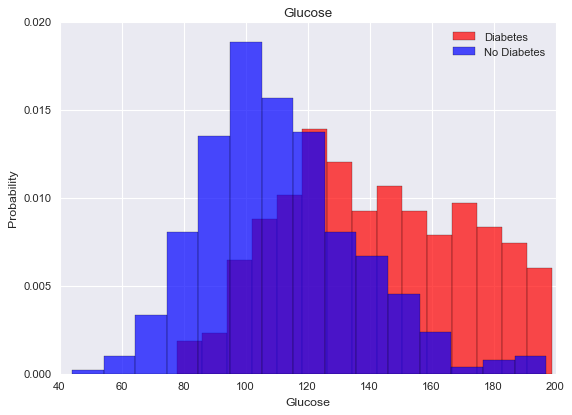

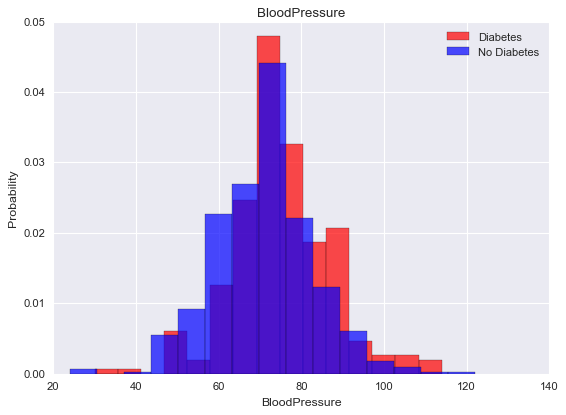

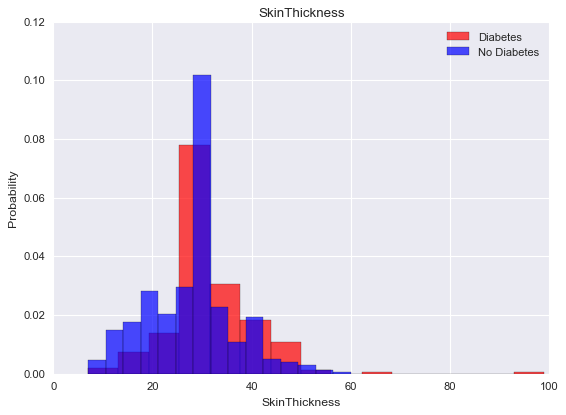

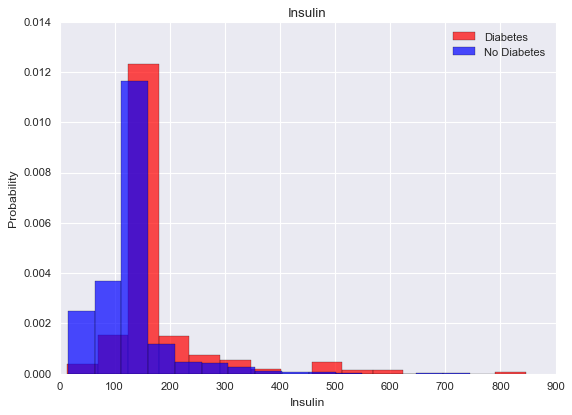

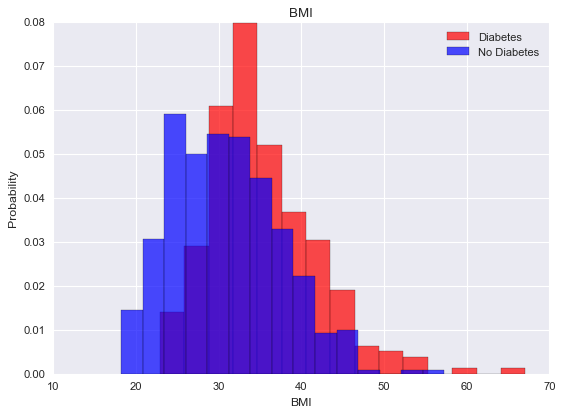

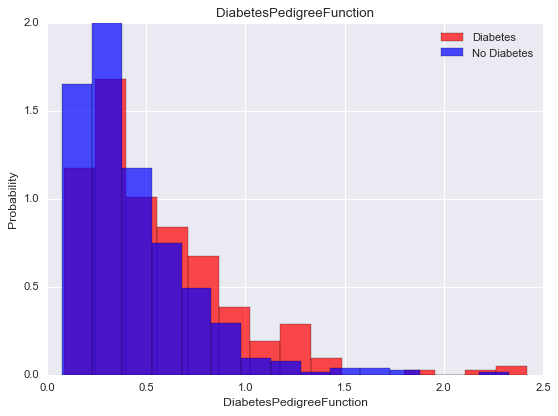

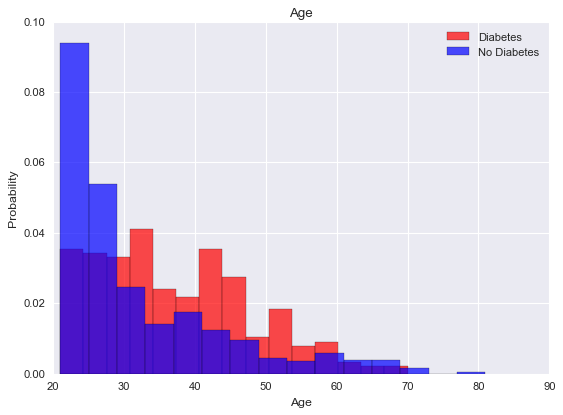

In [400]:
# df_copy.hist(figsize=(20, 20))
for i in range(len(df_copy.columns[:-1])):
    label = df_copy.columns[i]
    plt.hist(
        df_copy[df_copy['Outcome'] == 1][label],
        color='red',
        label='Diabetes',
        alpha=0.7,
        density=True,
        bins=15
    )

    plt.hist(
        df_copy[df_copy['Outcome'] == 0][label],
        color='blue',
        label='No Diabetes',
        alpha=0.7,
        density=True,
        bins=15
    )

    plt.title(label)
    plt.ylabel('Probability')
    plt.xlabel(label)
    plt.legend()
    plt.show()

Outcome
0    500
1    268
Name: count, dtype: int64


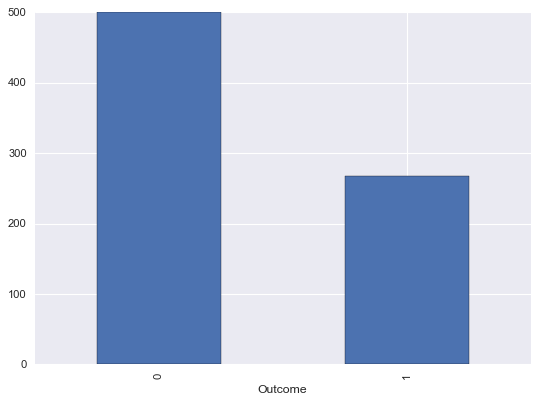

In [401]:

color_wheel = {0: "#0392cf", 1: "#7bc043"}
colors = df_copy["Outcome"].map(lambda x: color_wheel.get(x))
print(df_copy.Outcome.value_counts())
p=df_copy.Outcome.value_counts().plot(kind="bar")


C:\Users\Hammam\AppData\Local\Temp\ipykernel_18560\1296595776.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(121), sns.distplot(df_copy['Insulin'])
c:\Users\Hammam\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Hammam\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na',

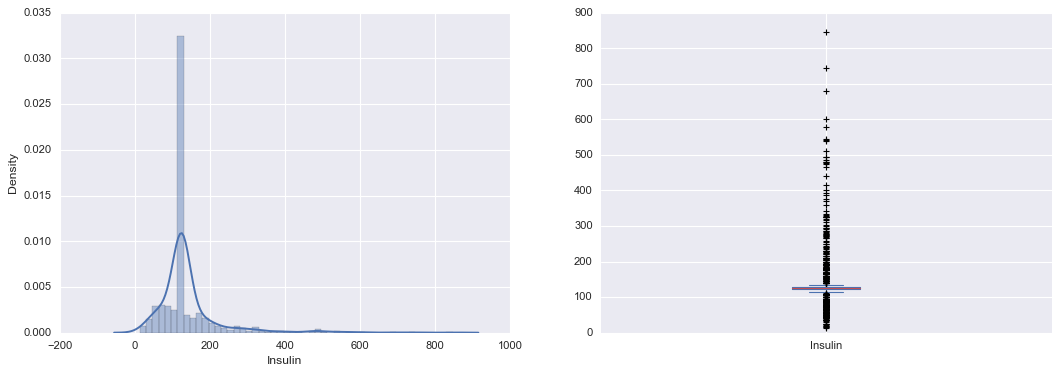

In [402]:
plt.subplot(121), sns.distplot(df_copy['Insulin'])
plt.subplot(122), df_copy['Insulin'].plot.box(figsize=(16,5))
plt.show()

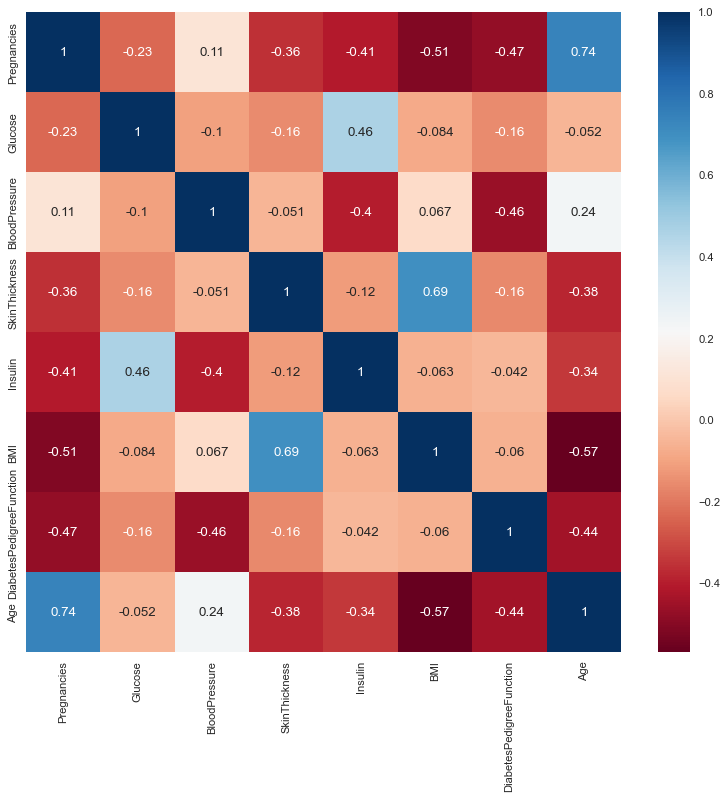

In [403]:
# Buang kolom-kolom dengan korelasi kurang dari 0.2
plt.figure(figsize=(12,10))
features = df_copy.drop(columns=['Outcome'])
label = df_copy['Outcome']

correlation_matrix = features.corr()
sns.heatmap(correlation_matrix.corr(), annot=True,cmap ='RdBu')
plt.show()

low_corr_features = correlation_matrix[abs(correlation_matrix) < 0.2]
df_copy = df_copy.drop(low_corr_features.columns, axis=1)

In [404]:
X = features
# y = df_copy['Outcome']
y = y

In [405]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Data Modeling

### Modeling with Keras

In [406]:
# Set random seed
tf.random.set_seed(42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

normalize = tf.keras.layers.Normalization()
normalize.adapt(X_train)

model = tf.keras.Sequential([
  tf.keras.layers.Dense(8, activation="elu"), 
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid") 
])

model.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                  metrics=['accuracy'])

# Fit the model
#class_weight = {0: 0.2, 1: 0.8}
history = model.fit(X_train, y_train, epochs=100,  validation_data=(X_test, y_test))

Epoch 1/100
17/17 [==============================] - 3s 34ms/step - loss: 0.7713 - accuracy: 0.5363 - val_loss: 0.6231 - val_accuracy: 0.6537
Epoch 2/100
17/17 [==============================] - 0s 8ms/step - loss: 0.5507 - accuracy: 0.7020 - val_loss: 0.5661 - val_accuracy: 0.7316
Epoch 3/100
17/17 [==============================] - 0s 14ms/step - loss: 0.5012 - accuracy: 0.7635 - val_loss: 0.5494 - val_accuracy: 0.7446
Epoch 4/100
17/17 [==============================] - 0s 15ms/step - loss: 0.4809 - accuracy: 0.7672 - val_loss: 0.5331 - val_accuracy: 0.7662
Epoch 5/100
17/17 [==============================] - 0s 11ms/step - loss: 0.4671 - accuracy: 0.7709 - val_loss: 0.5302 - val_accuracy: 0.7489
Epoch 6/100
17/17 [==============================] - 0s 9ms/step - loss: 0.4568 - accuracy: 0.7784 - val_loss: 0.5293 - val_accuracy: 0.7489
Epoch 7/100
17/17 [==============================] - 0s 8ms/step - loss: 0.4535 - accuracy: 0.7728 - val_loss: 0.5348 - val_accuracy: 0.7403
Epoch 8/1

### Modeling with lgbm

In [413]:
model2 = lgb.LGBMRegressor(learning_rate=0.09,max_depth=-5,random_state=42)


# history2 = model2.fit(X_train, y_train, epochs=100,  validation_data=(X_test, y_test))
history2 = model2.fit(X_train,y_train, eval_set=[(X_test,y_test),(X_train,y_train)],
          eval_metric='logloss')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 608
[LightGBM] [Info] Number of data points in the train set: 537, number of used features: 8
[LightGBM] [Info] Start training from score 0.350093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [414]:
from lightgbm import LGBMClassifier
model3 = LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42,)
history3 = model3.fit(X_train,y_train, eval_set=[(X_test,y_test),(X_train,y_train)],
          eval_metric='logloss')

[LightGBM] [Info] Number of positive: 188, number of negative: 349
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 608
[LightGBM] [Info] Number of data points in the train set: 537, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.350093 -> initscore=-0.618630
[LightGBM] [Info] Start training from score -0.618630
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [415]:
acc = history.history
# acc2 = history2.
# acc3 = history3.history

Text(0.5, 1.0, 'Keras Accuracy')

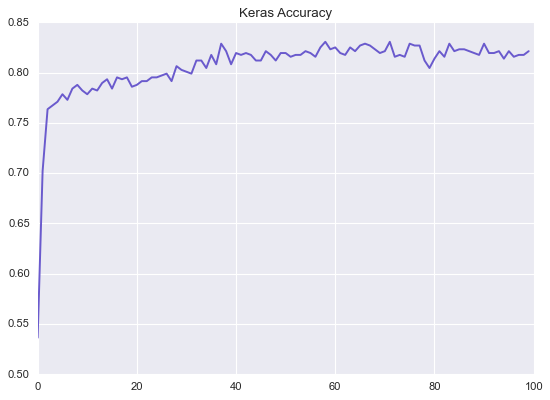

In [416]:
plt.plot(acc['accuracy'], color = 'slateblue')
plt.title('Keras Accuracy')
# plt.show()
# plt.plot(acc2['accuracy'], color = 'orangered')
# plt.title('LGBM Regressor Accuracy')
# plt.show()
# plt.plot(acc3['accuracy'], color = 'cyan')
# plt.title('LGBM Classifier Accuracy')
# plt.show()

# Model Evaluation

In [419]:
loss, accuracy = model.evaluate(X_test, y_test)
# loss2, accuracy2 = model2.evaluate(X_test, y_test)
# loss3, accuracy3 = model3.evaluate(X_test, y_test)

print(f"Model loss on test set: {loss}")
print(f"Model accuracy on test set: {(accuracy*100):.2f}%")
print("-"*30)
print('Training accuracy {:.4f}'.format(model2.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(model2.score(X_test,y_test)))
print("-"*30)
print('Training accuracy {:.4f}'.format(model3.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(model3.score(X_test,y_test)))
print("-"*30)

8/8 [==============================] - 0s 4ms/step - loss: 0.5712 - accuracy: 0.7316
Model loss on test set: 0.5712189674377441
Model accuracy on test set: 73.16%
------------------------------


In [420]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix

# Make predictions
y_preds = model.predict(X_test)
y_preds2 = model2.predict(X_test)
y_preds3 = model3.predict(X_test)

# Create confusion matrix
confusion_matrix(y_test, tf.round(y_preds))

8/8 [==============================] - 0s 3ms/step


array([[124,  27],
       [ 35,  45]], dtype=int64)

In [421]:
confusion_matrix(y_test, tf.round(y_preds2))

array([[115,  36],
       [ 27,  53]], dtype=int64)

In [422]:
confusion_matrix(y_test, tf.round(y_preds3))

array([[116,  35],
       [ 23,  57]], dtype=int64)

In [423]:
def show_confusion_matrix(ytest, ypred):
    figsize = (10, 10)

    # Create the confusion matrix
    cm = confusion_matrix(ytest, tf.round(ypred))
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0]

    # Let's prettify it
    fig, ax = plt.subplots(figsize=figsize)
    # Create a matrix plot
    cax = ax.matshow(cm, cmap=plt.cm.Blues) 
    fig.colorbar(cax)

    # Create classes
    classes = False

    if classes:
      labels = classes
    else:
      labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
          xlabel="Predicted label",
          ylabel="True label",
          xticks=np.arange(n_classes),
          yticks=np.arange(n_classes),
          xticklabels=labels,
          yticklabels=labels)

    # Set x-axis labels to bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Adjust label size
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.title.set_size(20)

    # Set threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=15)

#### Confusion matrix Keras

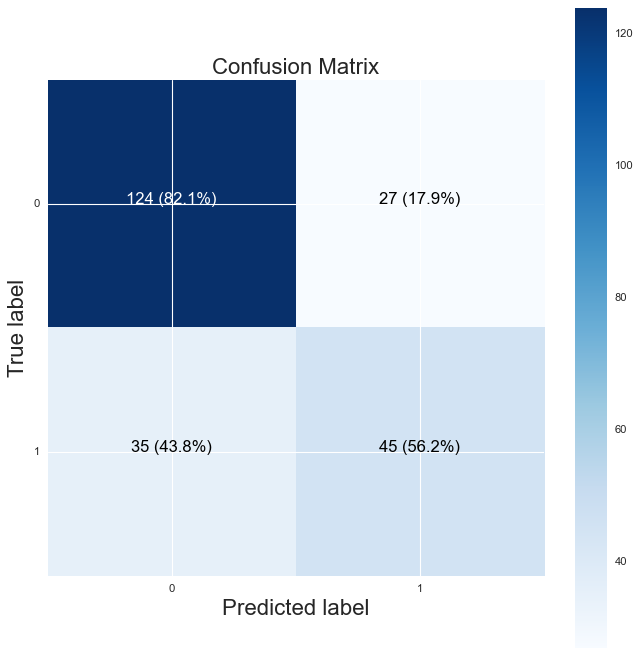

In [424]:
show_confusion_matrix(y_test, y_preds)

### COnfusion matrix LGBM Regressor

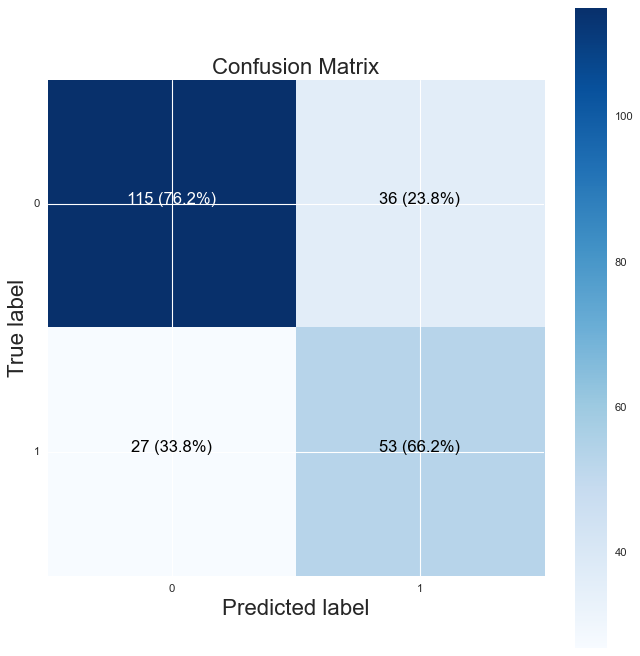

In [425]:
show_confusion_matrix(y_test, y_preds2)

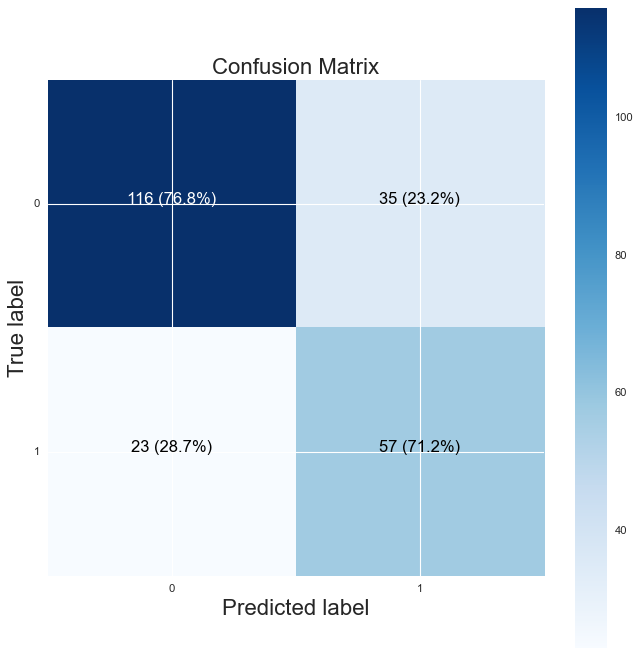

In [426]:
show_confusion_matrix(y_test, y_preds3)

### Remove feature with correlation to outcome less than 0.2

In [432]:
y = df['Outcome']
X = df.drop(columns=['Outcome'])
X2 = X.drop(columns=['BloodPressure','SkinThickness','Insulin','DiabetesPedigreeFunction'], axis=0)

X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.25, random_state=42)

In [440]:
tf.random.set_seed(42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

normalize = tf.keras.layers.Normalization()
normalize.adapt(X_train)

model = tf.keras.Sequential([
  tf.keras.layers.Dense(20, activation="elu"), 
  tf.keras.layers.Dense(20, activation="elu"),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid") 
])

model.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                  metrics=['accuracy'])

# Fit the model
#class_weight = {0: 0.2, 1: 0.8}
history = model.fit(X_train, y_train, epochs=100,  validation_data=(X_test, y_test))

Epoch 1/100
18/18 [==============================] - 4s 51ms/step - loss: 0.5063 - accuracy: 0.7378 - val_loss: 0.5779 - val_accuracy: 0.7344
Epoch 2/100
18/18 [==============================] - 0s 11ms/step - loss: 0.4635 - accuracy: 0.7795 - val_loss: 0.5515 - val_accuracy: 0.7240
Epoch 3/100
18/18 [==============================] - 0s 11ms/step - loss: 0.4591 - accuracy: 0.7726 - val_loss: 0.5487 - val_accuracy: 0.7396
Epoch 4/100
18/18 [==============================] - 0s 11ms/step - loss: 0.4548 - accuracy: 0.7847 - val_loss: 0.5511 - val_accuracy: 0.7344
Epoch 5/100
18/18 [==============================] - 0s 12ms/step - loss: 0.4523 - accuracy: 0.7847 - val_loss: 0.5638 - val_accuracy: 0.7188
Epoch 6/100
18/18 [==============================] - 0s 13ms/step - loss: 0.4550 - accuracy: 0.7830 - val_loss: 0.5496 - val_accuracy: 0.7292
Epoch 7/100
18/18 [==============================] - 0s 18ms/step - loss: 0.4509 - accuracy: 0.7812 - val_loss: 0.5596 - val_accuracy: 0.7240
Epoch 

In [441]:
model2 = lgb.LGBMRegressor(learning_rate=0.09,max_depth=-5,random_state=42,)

model2.fit(X_train,y_train, eval_set=[(X_test,y_test),(X_train,y_train)],
          eval_metric='logloss')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289
[LightGBM] [Info] Number of data points in the train set: 576, number of used features: 4
[LightGBM] [Info] Start training from score 0.345486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor(learning_rate=0.09, max_depth=-5, random_state=42)

In [442]:
model3 = LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42, metrics='accuracy')
model3.fit(X_train,y_train, eval_set=[(X_test,y_test),(X_train,y_train)],
          eval_metric='logloss')

[LightGBM] [Info] Number of positive: 199, number of negative: 377
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289
[LightGBM] [Info] Number of data points in the train set: 576, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345486 -> initscore=-0.638940
[LightGBM] [Info] Start training from score -0.638940
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

LGBMClassifier(learning_rate=0.09, max_depth=-5, metrics='accuracy',
               random_state=42)

In [443]:
loss, accuracy = model.evaluate(X_test, y_test)

print(f"Model loss on test set: {loss}")
print(f"Model accuracy on test set: {(accuracy*100):.2f}%")
print("-"*30)
print('Training accuracy {:.4f}'.format(model2.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(model2.score(X_test,y_test)))
print("-"*30)
print('Training accuracy {:.4f}'.format(model3.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(model3.score(X_test,y_test)))
print("-"*30)

6/6 [==============================] - 0s 4ms/step - loss: 0.5568 - accuracy: 0.7396
Model loss on test set: 0.5568192005157471
Model accuracy on test set: 73.96%
------------------------------
Training accuracy 0.7608
Testing accuracy 0.1313
------------------------------
Training accuracy 0.9826
Testing accuracy 0.7083
------------------------------


In [444]:
from sklearn.metrics import confusion_matrix

# Make predictions
y_preds = model.predict(X_test)
y_preds2 = model2.predict(X_test)
y_preds3 = model3.predict(X_test)

# Create confusion matrix
display(confusion_matrix(y_test, tf.round(y_preds)))
display(confusion_matrix(y_test, tf.round(y_preds2)))
display(confusion_matrix(y_test, tf.round(y_preds3)))

6/6 [==============================] - 0s 3ms/step


array([[96, 27],
       [23, 46]], dtype=int64)

array([[90, 33],
       [30, 39]], dtype=int64)

array([[93, 30],
       [26, 43]], dtype=int64)